In [1]:
cd ..

d:\research\fedmiss_bench


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
import pandas as pd
from src.loaders.load_data import load_data
from collections import OrderedDict
import numpy as np

In [3]:
from sklearn.preprocessing import KBinsDiscretizer
X = np.random.choice([0, 1], size=(100, 1))
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample = None)
est.fit_transform(X)

array([[0.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [0.],
       [0.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],

## Functions

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_heatmap(df, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt=".1f")
    plt.show()

In [5]:
def avg_correlation(df):
    avg_correlation_cols = list(OrderedDict(df.corr().abs().mean().sort_values(ascending=False).to_dict()).items())
    features = set(df.columns.tolist()[:-1])
    avg_correlation_cols = [col for col in avg_correlation_cols if col[0] in features]
    return avg_correlation_cols

In [6]:
from sklearn.cluster import KMeans
def kbins(data, data_config):

    est = KMeans(n_clusters=10, random_state=0)

    X = data.iloc[:, data_config['split_col_idx']].values
    X = est.fit_predict(X)
    
    return X

## Codrna

In [7]:
df, data_config = load_data('codrna')
show_heatmap(df,  figsize = (6,4))
print(avg_correlation(df))
print(data_config)

In [38]:
avg_cols = avg_correlation(df)
avg_cols = [col[0] for col in avg_cols]
split_col_idx = [df.columns.tolist().index(col) for col in avg_cols]
split_col_idx

In [63]:
cl = kbins(df, data_config)
np.unique(cl, return_counts=True)

In [41]:
data_config

## HHP

In [95]:

############################################################################################################
# Load data
# members
df_members = pd.read_csv('./data/HHP_herritage_health/Members.csv')
df_members['Sex'] = df_members['Sex'].map({'M': 1, 'F': 0})
df_members['AgeAtFirstClaim'] = df_members['AgeAtFirstClaim'].map({
    '0-9': 5,
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80+': 90
})

# drug and lab
df_drug = pd.read_csv('./data/HHP_herritage_health/DrugCount.csv')
df_drug['DrugCount'] = df_drug['DrugCount'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7+': 10})
df_lab = pd.read_csv('./data/HHP_herritage_health/LabCount.csv')
df_lab['LabCount'] = df_lab['LabCount'].map(
    {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 12}
)

# days
df_days_y2 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y2.csv')
df_days_y2['Year'] = 'Y1'
df_days_y3 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y3.csv')
df_days_y3['Year'] = 'Y2'

df_days = pd.concat([df_days_y2, df_days_y3])

df_claims = pd.read_csv('./data/HHP_herritage_health/Claims.csv')

# divide by provider
# providers = df_claims['ProviderID'].value_counts().iloc[: 10].index.tolist()
# df_claims = df_claims[df_claims['ProviderID'].isin(providers)]
# print(df_claims.shape)

df_claims = pd.merge(df_claims, df_members, on='MemberID', how='left')
df_claims = pd.merge(df_claims, df_drug, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_lab, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_days, on=['MemberID', 'Year'], how='left')
df_claims = df_claims[df_claims['DaysInHospital'].notna()]
print(df_claims.shape)

#################################################################################################################
# Feature engineering
# drop missing age and sex
df_claims = df_claims[df_claims['AgeAtFirstClaim'].notna()].copy()
df_claims = df_claims[df_claims['Sex'].notna()].copy()
df_claims = df_claims[df_claims['DSFS'].notna()].copy()

# transform categorical columns
def transform1(row):
    if pd.isna(row):
        return 'None'
    else:
        return str(int(row))
    
df_claims['ProviderID'] = df_claims['ProviderID'].map(transform1)
df_claims['Vendor'] = df_claims['Vendor'].map(transform1)
df_claims['PCP'] = df_claims['PCP'].map(transform1)

# handle missing values for categorical columns
df_claims['ProcedureGroup'] = df_claims['ProcedureGroup'].fillna('None', inplace=False)
df_claims['Specialty'] = df_claims['Specialty'].fillna('None', inplace=False)
df_claims['PrimaryConditionGroup'] = df_claims['PrimaryConditionGroup'].fillna('None', inplace=False)
df_claims['PlaceSvc'] = df_claims['PlaceSvc'].fillna('None', inplace=False)

# encode number of columns
df_claims['CharlsonIndex'] = df_claims['CharlsonIndex'].map({'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 7})
df_claims['PayDelay'] = df_claims['PayDelay'].apply(lambda row: int(row) if row != '162+' else 200)
df_claims['LengthOfStay'] = df_claims['LengthOfStay'].map({
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21, '4- 8 weeks': 42,
})
df_claims['DSFS'] = df_claims['DSFS'].map({
    '0- 1 month': 1, '1- 2 months': 2, '2- 3 months': 3, '3- 4 months': 4, '4- 5 months': 5, '5- 6 months': 6, 
    '6- 7 months': 7, '7- 8 months': 8, '8- 9 months': 9, '9-10 months': 10, '10-11 months': 11, '11-12 months': 12
})

# filter all large claims
df_claims = df_claims[df_claims['DaysInHospital'] > 0].copy()
print(df_claims.shape)

# fill mean values for drug and lab counts
df_claims['DrugCount'] = df_claims['DrugCount'].fillna(df_claims['DrugCount'].mean(), inplace=False)
df_claims['LabCount'] = df_claims['LabCount'].fillna(df_claims['LabCount'].mean(), inplace=False)

# drop length of stay
df_claims = df_claims.drop(columns=['LengthOfStay'])

#########################################################################################################################
# Feature selection
# numerical features
def feature_agg(df, key):
    ret = df.groupby(['MemberID', 'Year']).agg(
        **{
            key+'_mean': pd.NamedAgg(column=key, aggfunc='mean'),
            key+'_std': pd.NamedAgg(column=key, aggfunc='std'),
            key+'_max': pd.NamedAgg(column=key, aggfunc='max'),
            key+'_min': pd.NamedAgg(column=key, aggfunc='min'),
        }
    )

    ret[f'{key}_range'] = ret[f'{key}_max'] - ret[f'{key}_min']
    ret = ret.reset_index()
    ret = ret.drop(columns=[f'{key}_min'])
    
    df = pd.merge(df, ret, on=['MemberID', 'Year'], how='left')
    df = df.drop(columns=[key])
    
    return df

df_claims = feature_agg(df_claims, 'DSFS')
df_claims = feature_agg(df_claims, 'PayDelay')
df_claims = feature_agg(df_claims, 'CharlsonIndex')
df_claims = feature_agg(df_claims, 'DrugCount')
df_claims = feature_agg(df_claims, 'LabCount')

def feature_agg2(df, key):
    df = df.groupby(['MemberID', 'Year']).agg(key).nunique().reset_index(name = key+'_counts')
    df = pd.merge(df_claims, df, on = ['MemberID', 'Year'], how = 'left')
    return df

df_claims = feature_agg2(df_claims, 'ProviderID')
df_claims = feature_agg2(df_claims, 'Vendor')
df_claims = feature_agg2(df_claims, 'PCP')
df_claims = feature_agg2(df_claims, 'Specialty')
df_claims = feature_agg2(df_claims, 'PlaceSvc')
df_claims = feature_agg2(df_claims, 'PrimaryConditionGroup')
df_claims = feature_agg2(df_claims, 'ProcedureGroup')
ret = df_claims.groupby(['MemberID', 'Year']).size().reset_index(name = 'claim_counts')
df_claims = pd.merge(df_claims, ret, on = ['MemberID', 'Year'], how = 'left')

df_claims.fillna(0, inplace=True)

# categoorical one-hot features
top_k = 2
for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup']:
    top_k_cols = pd.get_dummies(df_claims[col]).corrwith(df_claims['DaysInHospital']).abs().sort_values(ascending = False)[:top_k]
    dummies = pd.get_dummies(df_claims[col])[top_k_cols.index]
    dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
    df_claims = pd.concat([df_claims, dummies], axis = 1)
    df_claims.drop(columns = [col], inplace = True)
    
df_claims = df_claims.drop(columns = ['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year'])

#########################################################################################################################
# Split data
# columns
num_cols = ['AgeAtFirstClaim']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print(len(num_cols))

cat_cols = ['Sex', 'SupLOS', 'ClaimsTruncated']
cat_cols += [f'{col}_{idx}' for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print(len(cat_cols))

target = 'DaysInHospital'

# sample data
df_claims_sample = df_claims.sample(n = 20000, random_state=42)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])
scaler = MinMaxScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])

# reorder target to be num cols, cat cols and target
df_claims_sample = df_claims_sample[num_cols + cat_cols + [target]]

print(df_claims_sample.shape)

data = df_claims_sample

avg_correlation_cols = avg_correlation(data)
avg_correlation_cols = [col[0] for col in avg_correlation_cols if col[0] in num_cols]
avg_correlation_cols = [col for col in avg_correlation_cols][:int(data.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
    'split_col_idx': [data.columns.tolist().index(col) for col in avg_correlation_cols],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    "num_cols": len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

(1764556, 20)
(207078, 20)
29
11
(20000, 41)


In [96]:
data_config

{'target': 'DaysInHospital',
 'features_idx': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 'split_col_idx': [28, 26, 21, 19, 20, 22, 24, 3, 8, 1, 17, 16],
 'ms_col_idx': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 'obs_col_idx': [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 'num_cols': 29,
 'task_type': 'regression',
 'clf_type': 'none',
 'data_type': 'tabular'}

In [136]:
import json
data.to_csv('./data/HHP_herritage_health/data_cleaned.csv', index=False)
with open('./data/HHP_herritage_health/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [132]:
data.shape

(20000, 41)

In [133]:
data_config['split_col_idx']

[28, 26, 21, 19, 20, 22, 24, 3, 8, 1, 17, 16]

In [134]:
avg_correlation(data[num_cols])

[('PrimaryConditionGroup_counts', 0.3864239983213965),
 ('DSFS_max', 0.379281518226531),
 ('DSFS_range', 0.37834153177851154),
 ('ProviderID_counts', 0.3705526369259498),
 ('Vendor_counts', 0.3486021132796735),
 ('Specialty_counts', 0.334115808932216),
 ('PayDelay_range', 0.32899664523259314),
 ('DSFS_mean', 0.3202303589213353),
 ('CharlsonIndex_max', 0.31769131604659934),
 ('DrugCount_range', 0.31404307198029224),
 ('CharlsonIndex_mean', 0.3070737286715878),
 ('PayDelay_max', 0.30628634315534065),
 ('ProcedureGroup_counts', 0.30367602120703774),
 ('DrugCount_max', 0.3035214282226342),
 ('LabCount_range', 0.29870500287843166),
 ('DSFS_std', 0.29154984045580734),
 ('DrugCount_std', 0.2852965709825898),
 ('PlaceSvc_counts', 0.2798536241838592),
 ('AgeAtFirstClaim', 0.277469585403599),
 ('CharlsonIndex_range', 0.25864202744291603),
 ('LabCount_max', 0.2573764414379535),
 ('LabCount_std', 0.25170822907034757),
 ('CharlsonIndex_std', 0.23800960834661064),
 ('PayDelay_std', 0.199927902829486

In [135]:
data[num_cols].corrwith(data['DaysInHospital']).abs().sort_values(ascending = False)

claim_counts                    0.192940
AgeAtFirstClaim                 0.167797
DrugCount_max                   0.165899
CharlsonIndex_mean              0.164417
CharlsonIndex_max               0.163108
PrimaryConditionGroup_counts    0.148388
DrugCount_range                 0.146674
DrugCount_mean                  0.136458
DrugCount_std                   0.135639
DSFS_mean                       0.132081
LabCount_range                  0.131676
DSFS_max                        0.123490
DSFS_range                      0.121696
ProviderID_counts               0.118740
Vendor_counts                   0.112199
CharlsonIndex_range             0.112028
LabCount_max                    0.109704
LabCount_std                    0.105888
CharlsonIndex_std               0.097125
PlaceSvc_counts                 0.095415
PayDelay_range                  0.087818
DSFS_std                        0.078829
Specialty_counts                0.074838
PayDelay_max                    0.073684
ProcedureGroup_c

In [6]:
data_config

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = df_claims_sample[num_cols]
y = df_claims_sample[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

In [56]:
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_log_error(y_test, y_pred)))

In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

## California Housing

In [19]:
from sklearn.preprocessing import PowerTransformer
def outlier_remove_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] >= (Q1 - 1.5 * IQR)) & (data[col] <= (Q3 + 1.5 * IQR))]
    return data

def convert_gaussian(data, col):
    pt = PowerTransformer()
    data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [73]:
from sklearn.datasets import fetch_california_housing, fetch_kddcup99
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
housing = fetch_california_housing()
data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
target_col = 'MedHouseVal'
data[target_col] = housing.target

# drop missing values
print(data.shape)
data = data.dropna()
print(data.shape)

# remove outliers
data = outlier_remove_iqr(data, 'AveRooms')
data = outlier_remove_iqr(data, 'AveBedrms')
data = outlier_remove_iqr(data, 'Population')
data = outlier_remove_iqr(data, 'AveOccup')

# gaussian transform
data = convert_gaussian(data, 'MedInc')

num_cols = data.columns.tolist()[:-1]

scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.shape)

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [0, 2, 5],
    'ms_col_idx': list(range(len(num_cols))),
    'obs_col_idx': [4, 7],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

print(data_config)

(20640, 9)
(20640, 9)
(17309, 9)
{'target': 'MedHouseVal', 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'split_col_idx': [0, 2, 5], 'ms_col_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'obs_col_idx': [4, 7], 'num_cols': 8, 'task_type': 'regression', 'clf_type': 'none', 'data_type': 'tabular'}


In [72]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

<Axes: >

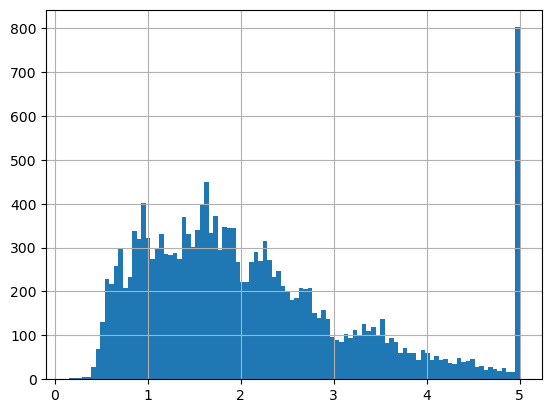

In [76]:
data[target_col].hist(bins=100)

In [74]:
data.to_csv('./data/california/data_cleaned.csv', index=False)
import json
with open('./data/california/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [62]:
data[num_cols].corrwith(data[target_col]).abs().sort_values(ascending = False)

MedInc        0.664471
AveRooms      0.348928
AveOccup      0.300296
Latitude      0.144745
HouseAge      0.113715
AveBedrms     0.079084
Population    0.047934
Longitude     0.039642
dtype: float64

In [63]:
avg_correlation(data[num_cols])

[('Latitude', 0.3028299648218262),
 ('MedInc', 0.28646477855582314),
 ('AveRooms', 0.28186323119560286),
 ('Population', 0.23566774029312026),
 ('HouseAge', 0.22605015420178803),
 ('AveOccup', 0.22438995954950725),
 ('AveBedrms', 0.1939950364378315)]

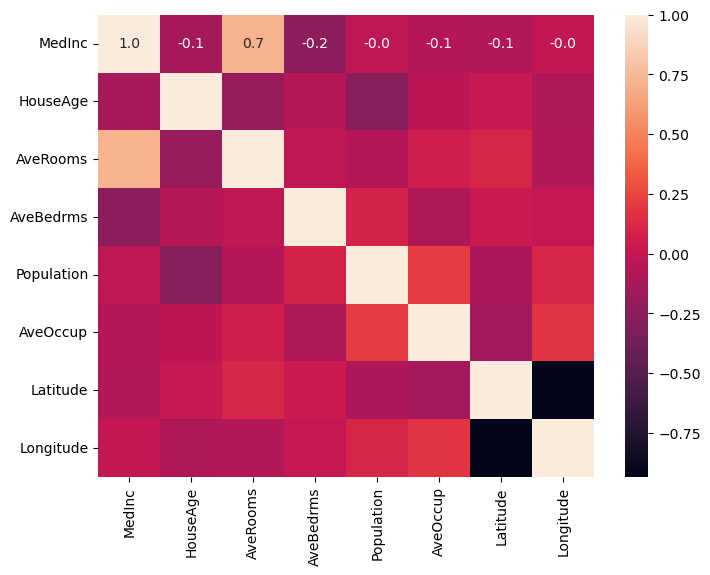

In [71]:
show_heatmap(data[num_cols])

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data[num_cols]
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 0.97413237
Iteration 2, loss = 0.45499365
Iteration 3, loss = 0.32533590
Iteration 4, loss = 0.28918070
Iteration 5, loss = 0.27170242
Iteration 6, loss = 0.25921498
Iteration 7, loss = 0.25179445
Iteration 8, loss = 0.24613219
Iteration 9, loss = 0.23848991
Iteration 10, loss = 0.23326281
Iteration 11, loss = 0.23049667
Iteration 12, loss = 0.22712086
Iteration 13, loss = 0.22382020
Iteration 14, loss = 0.22039476
Iteration 15, loss = 0.21756251
Iteration 16, loss = 0.21669183
Iteration 17, loss = 0.21452886
Iteration 18, loss = 0.21177884
Iteration 19, loss = 0.21107140
Iteration 20, loss = 0.21204991
Iteration 21, loss = 0.21017200
Iteration 22, loss = 0.20922645
Iteration 23, loss = 0.20517622
Iteration 24, loss = 0.20462825
Iteration 25, loss = 0.20369707
Iteration 26, loss = 0.20428438
Iteration 27, loss = 0.20535756
Iteration 28, loss = 0.20225805
Iteration 29, loss = 0.20209686
Iteration 30, loss = 0.20007093
Iteration 31, loss = 0.20116552
Iteration 32, los

## Dvisits

In [40]:
! pip install pyreadr

In [41]:
def convert_gaussian(data, col):
    pt = PowerTransformer()
    data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [42]:
import pyreadr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
result = pyreadr.read_r('./data/dvisits/dvisits.rda')  
data = result['dvisits']
data = data.drop(['prescrib', 'nonpresc', 'agesq'], axis=1)
print(data.shape)

num_cols = ['age', 'income', 'illness', 'actdays', 'hscore', 'hospadmi', 'hospdays']
cat_cols = ['sex', 'levyplus', 'freepoor', 'freerepa', 'chcond1', 'chcond2']
target_col = 'medicine'

data = data[num_cols + cat_cols + [target_col]]

scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])
data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.shape)

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [0, 2, 1],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

print(data_config)


(5190, 16)
(5190, 14)
{'target': 'medicine', 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'split_col_idx': [0, 2, 1], 'ms_col_idx': [0, 1, 2, 3, 4, 5, 6], 'obs_col_idx': [7, 8, 9, 10, 11, 12], 'num_cols': 7, 'task_type': 'regression', 'clf_type': 'none', 'data_type': 'tabular'}


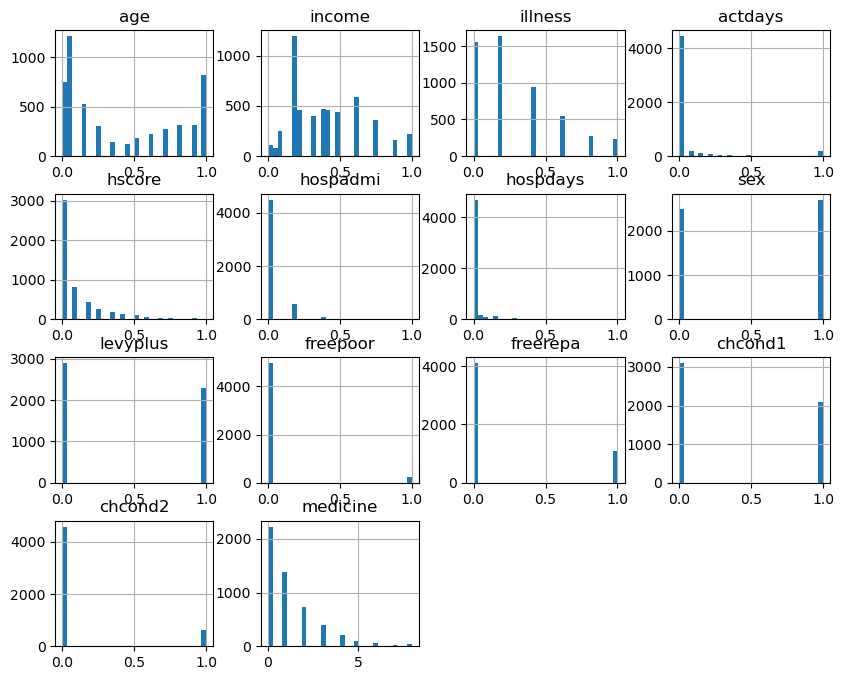

In [45]:
data.hist(bins=30, figsize=(10, 8))
plt.show()

In [70]:
data.columns

Index(['age', 'income', 'illness', 'actdays', 'hscore', 'hospadmi', 'hospdays',
       'sex', 'levyplus', 'freepoor', 'freerepa', 'chcond1', 'chcond2',
       'medicine'],
      dtype='object')

In [14]:
data.to_csv('./data/dvisits/data_cleaned.csv', index=False)
import json
with open('./data/dvisits/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [89]:
data.corrwith(data[target_col]).abs().sort_values(ascending = False)

medicine    1.000000
illness     0.456117
age         0.376949
freerepa    0.281884
sex         0.267897
actdays     0.246586
chcond2     0.241836
chcond1     0.236797
hscore      0.225632
hospadmi    0.200588
income      0.160023
hospdays    0.158207
freepoor    0.070637
levyplus    0.003904
dtype: float64

In [90]:
avg_correlation(data)

[('freerepa', 0.2826145712448704),
 ('age', 0.2625496803857044),
 ('illness', 0.25237472403728173),
 ('income', 0.22401358557175016),
 ('chcond2', 0.2095798630573001),
 ('hospadmi', 0.1944899482283382),
 ('actdays', 0.19392312564135078),
 ('hscore', 0.19298498719252102),
 ('hospdays', 0.19012308652873464),
 ('sex', 0.1899074065874176),
 ('chcond1', 0.1881901645393886),
 ('levyplus', 0.16329809452571434),
 ('freepoor', 0.13762939273313893)]

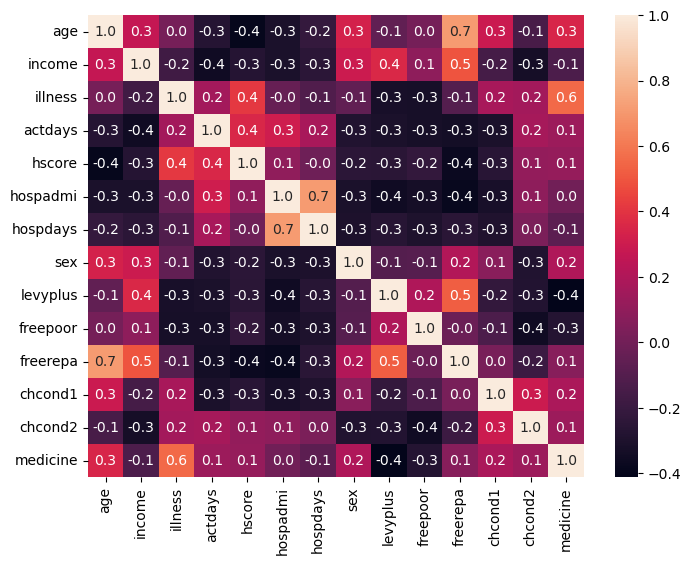

In [71]:
show_heatmap(data.corr().abs())

In [84]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data[cat_cols]
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 1.58173323
Iteration 2, loss = 1.22986278
Iteration 3, loss = 1.17542533
Iteration 4, loss = 1.15623827
Iteration 5, loss = 1.14231503
Iteration 6, loss = 1.13304195
Iteration 7, loss = 1.12630672
Iteration 8, loss = 1.11970077
Iteration 9, loss = 1.11538334
Iteration 10, loss = 1.11094547
Iteration 11, loss = 1.10785742
Iteration 12, loss = 1.10483637
Iteration 13, loss = 1.10291780
Iteration 14, loss = 1.10111231
Iteration 15, loss = 1.09939165
Iteration 16, loss = 1.09731088
Iteration 17, loss = 1.09484945
Iteration 18, loss = 1.09261121
Iteration 19, loss = 1.09151434
Iteration 20, loss = 1.09065897
Iteration 21, loss = 1.09021606
Iteration 22, loss = 1.08789014
Iteration 23, loss = 1.09313986
Iteration 24, loss = 1.08812165
Iteration 25, loss = 1.08524340
Iteration 26, loss = 1.08370521
Iteration 27, loss = 1.08469365
Iteration 28, loss = 1.08685355
Iteration 29, loss = 1.08275925
Iteration 30, loss = 1.08461600
Iteration 31, loss = 1.07990213
Iteration 32, los

## Vehicle

In [46]:
import scipy.io
from collections import Counter

In [47]:
mat = scipy.io.loadmat('./data/vehicle/vehicle.mat')
raw_x, raw_y = mat['X'], mat['Y']  # y = {-1, 1}
assert len(raw_x) == len(raw_y)
num_clients = len(raw_x)

dataset = []
for i in range(num_clients):
    features, labels = raw_x[i][0], raw_y[i][0].flatten()
    print(raw_x[i][0].shape, raw_y[i][0].shape)
    assert len(features) == len(labels)
    counter = Counter(labels)
    print(f'Client {i}:', counter, counter[1] / len(labels))
    dataset.append((features, labels))

positive_counts = [np.count_nonzero(labels + 1) for feats, labels in dataset]
positive_percentages = [np.count_nonzero(labels + 1) / len(labels) * 100
                      for feats, labels in dataset]

(2578, 100) (2578, 1)
Client 0: Counter({-1: 1296, 1: 1282}) 0.4972847168347556
(1511, 100) (1511, 1)
Client 1: Counter({1: 787, -1: 724}) 0.5208471211118465
(1519, 100) (1519, 1)
Client 2: Counter({-1: 773, 1: 746}) 0.4911125740618828
(1425, 100) (1425, 1)
Client 3: Counter({1: 760, -1: 665}) 0.5333333333333333
(1375, 100) (1375, 1)
Client 4: Counter({1: 738, -1: 637}) 0.5367272727272727
(1164, 100) (1164, 1)
Client 5: Counter({-1: 629, 1: 535}) 0.45962199312714774
(1683, 100) (1683, 1)
Client 6: Counter({1: 889, -1: 794}) 0.5282234105763518
(1735, 100) (1735, 1)
Client 7: Counter({1: 918, -1: 817}) 0.5291066282420749
(2000, 100) (2000, 1)
Client 8: Counter({-1: 1080, 1: 920}) 0.46
(1701, 100) (1701, 1)
Client 9: Counter({1: 920, -1: 781}) 0.5408583186360965
(1803, 100) (1803, 1)
Client 10: Counter({1: 1021, -1: 782}) 0.5662784248474765
(1803, 100) (1803, 1)
Client 11: Counter({1: 1050, -1: 753}) 0.5823627287853578
(1954, 100) (1954, 1)
Client 12: Counter({1: 1165, -1: 789}) 0.5962128

In [48]:
from src.evaluation.imp_quality_metrics import sliced_ws

dfs = []
for i in range(num_clients):
    df = pd.DataFrame(dataset[i][0])
    df['label'] = dataset[i][1]
    dfs.append(df)

final_df = pd.concat(dfs, axis=0)
split_indices = np.cumsum([df.shape[0] for df in dfs[:-1]])
print(split_indices)
print(final_df.shape)
final_df

[ 2578  4089  5608  7033  8408  9572 11255 12990 14990 16691 18494 20297
 22251 24451 26665 28579 30647 32609 34896 36898 38966 41414]
(43695, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-0.026949,1.000000,-0.014910,0.208563,0.158102,0.039686,-0.013324,-0.035059,-0.008879,0.017945,...,-0.027388,-0.027935,-0.029798,-0.029593,-0.024313,-0.028010,-0.030740,-0.029914,-0.019367,-1
1,-0.106449,-0.107161,-0.106211,-0.093109,-0.089204,-0.053121,-0.055886,0.311498,0.025716,0.378854,...,-0.046013,-0.045302,-0.046113,-0.046236,-0.046539,-0.046634,-0.046516,-0.046237,-0.046116,1
2,0.068916,0.184358,-0.019856,0.001814,-0.024399,-0.033020,0.069365,-0.030932,-0.004282,0.017541,...,-0.031355,-0.031642,-0.031202,-0.031654,-0.031389,-0.031540,-0.031497,-0.031652,-0.031654,1
3,0.274499,1.000000,0.422736,0.633032,0.060786,0.360998,0.142695,0.113041,-0.031728,0.199972,...,-0.025026,-0.024999,-0.025039,-0.024911,-0.024723,-0.025070,-0.024869,-0.024929,-0.025028,1
4,-0.111166,-0.046058,-0.082908,-0.064768,-0.066406,0.051794,-0.013235,0.246351,0.201614,1.000000,...,-0.067764,-0.067829,-0.067163,-0.066253,-0.068051,-0.067464,-0.067823,-0.067979,-0.068324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276,-0.054384,0.411459,0.460583,1.000000,0.523396,0.646742,0.842954,0.387761,0.126027,0.748298,...,-0.043342,-0.049038,-0.013036,-0.043912,-0.049354,-0.048903,-0.046344,-0.050182,-0.050180,1
2277,-0.104634,-0.097174,-0.075234,0.156365,1.000000,0.016999,-0.030837,-0.040085,0.767782,0.056683,...,-0.038803,-0.043465,-0.040676,-0.037836,-0.040370,-0.040014,-0.043179,-0.041937,-0.032778,1
2278,-0.124715,-0.129231,-0.107464,-0.093799,-0.134166,-0.009438,1.000000,0.400542,0.147469,0.248877,...,-0.020933,-0.020823,-0.020908,-0.021151,-0.021393,-0.021440,-0.021418,-0.021369,-0.021349,1
2279,1.000000,0.158975,0.397572,0.120110,0.236249,0.107046,0.121457,-0.051589,-0.053459,-0.047078,...,-0.024518,-0.049658,-0.023918,-0.048912,-0.041751,-0.045467,-0.010284,-0.052035,-0.058835,-1


In [49]:
# Number of clients/dataframes
num_dfs = len(dfs)
distance_matrix = np.zeros((num_dfs, num_dfs))

for i in range(num_dfs):
    for j in range(i + 1, num_dfs):
        # Assuming sliced_ws expects numpy arrays; adapt if necessary
        dist = sliced_ws(dfs[i].to_numpy(), dfs[j].to_numpy())
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Optional: Fill diagonal with zeros, assuming self-distance is zero
np.fill_diagonal(distance_matrix, 0)

# Average distance for each dataframe
average_distances = np.mean(distance_matrix, axis=1)

# Create an array of dataframe indices for reference
df_indices = np.arange(num_dfs)

# Combine indices and their corresponding average distances
average_distances_with_indices = list(zip(df_indices, average_distances))

# Sort the list of tuples by the average distance in descending order
sorted_by_distance = sorted(average_distances_with_indices, key=lambda x: x[1], reverse=True)

# Select the top 10
top_10_different = sorted_by_distance[:10]

# Unpack the top 10 list to separate indices and distances for clearer output
top_10_indices = [item[0] for item in top_10_different]
top_10_distances = [item[1] for item in top_10_different]

In [50]:
# feature selection
selected_dfs = [dfs[i] for i in top_10_indices]
selected_df = pd.concat(selected_dfs, axis=0)

from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier based on your task

# Assuming 'label' is your prediction target
X = selected_df.drop('label', axis=1)
y = selected_df['label']

model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

sorted_features = [feature[0] for feature in sorted_features if feature[1] > 0.01]
print(sorted_features)

correlated_cols = selected_df.corrwith(selected_df['label']).abs().sort_values(ascending = False)[:30].index.tolist()
print(correlated_cols)

final_cols = list(set(sorted_features) | set(correlated_cols))
final_cols.remove('label')
print(final_cols)

[0, 4, 5, 1, 52, 6, 3, 51, 11, 58, 53, 40, 54, 10, 7, 14]
['label', 40, 41, 42, 44, 43, 47, 48, 37, 49, 46, 45, 8, 39, 9, 10, 38, 11, 7, 4, 36, 1, 51, 35, 3, 53, 6, 58, 52, 50]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 58]


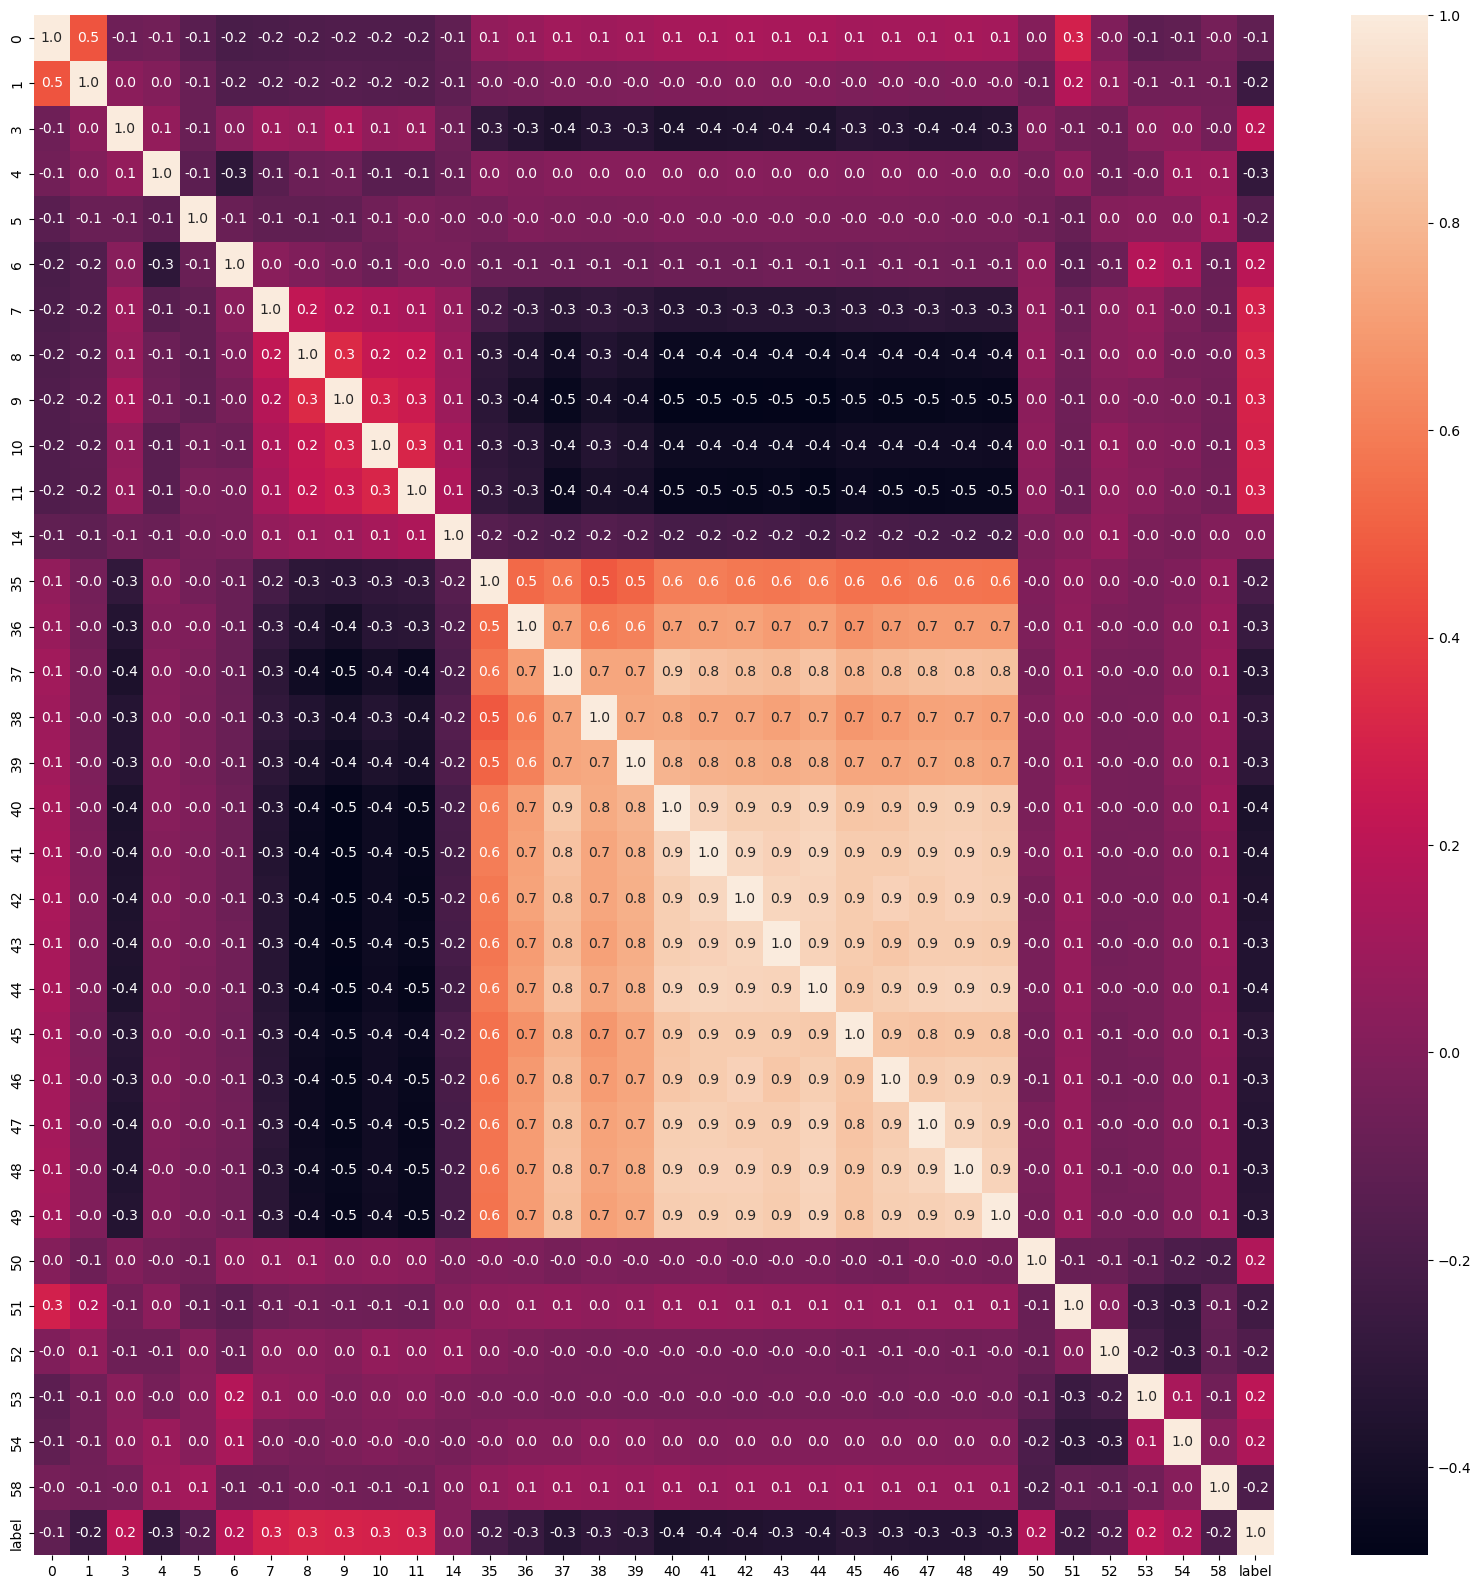

In [51]:
show_heatmap(selected_df[final_cols + ['label']], figsize=(20, 20))

In [87]:
data = selected_df[final_cols]
data = data.drop(columns = [41, 42, 43, 37, 44, 47, 46, 49, 45, 48])
print(data.shape)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

# gaussian transform
from sklearn.preprocessing import QuantileTransformer

# Assuming 'df' is your DataFrame with binary features
gaussian_cols = [11, 14, 35, 36, 38, 39, 40, 50, 58]
transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_gaussianized = transformer.fit_transform(data[gaussian_cols])
df_gaussianized = pd.DataFrame(df_gaussianized, columns=gaussian_cols)
data = pd.concat([data.drop(columns = gaussian_cols), df_gaussianized], axis = 1)

(18111, 23)


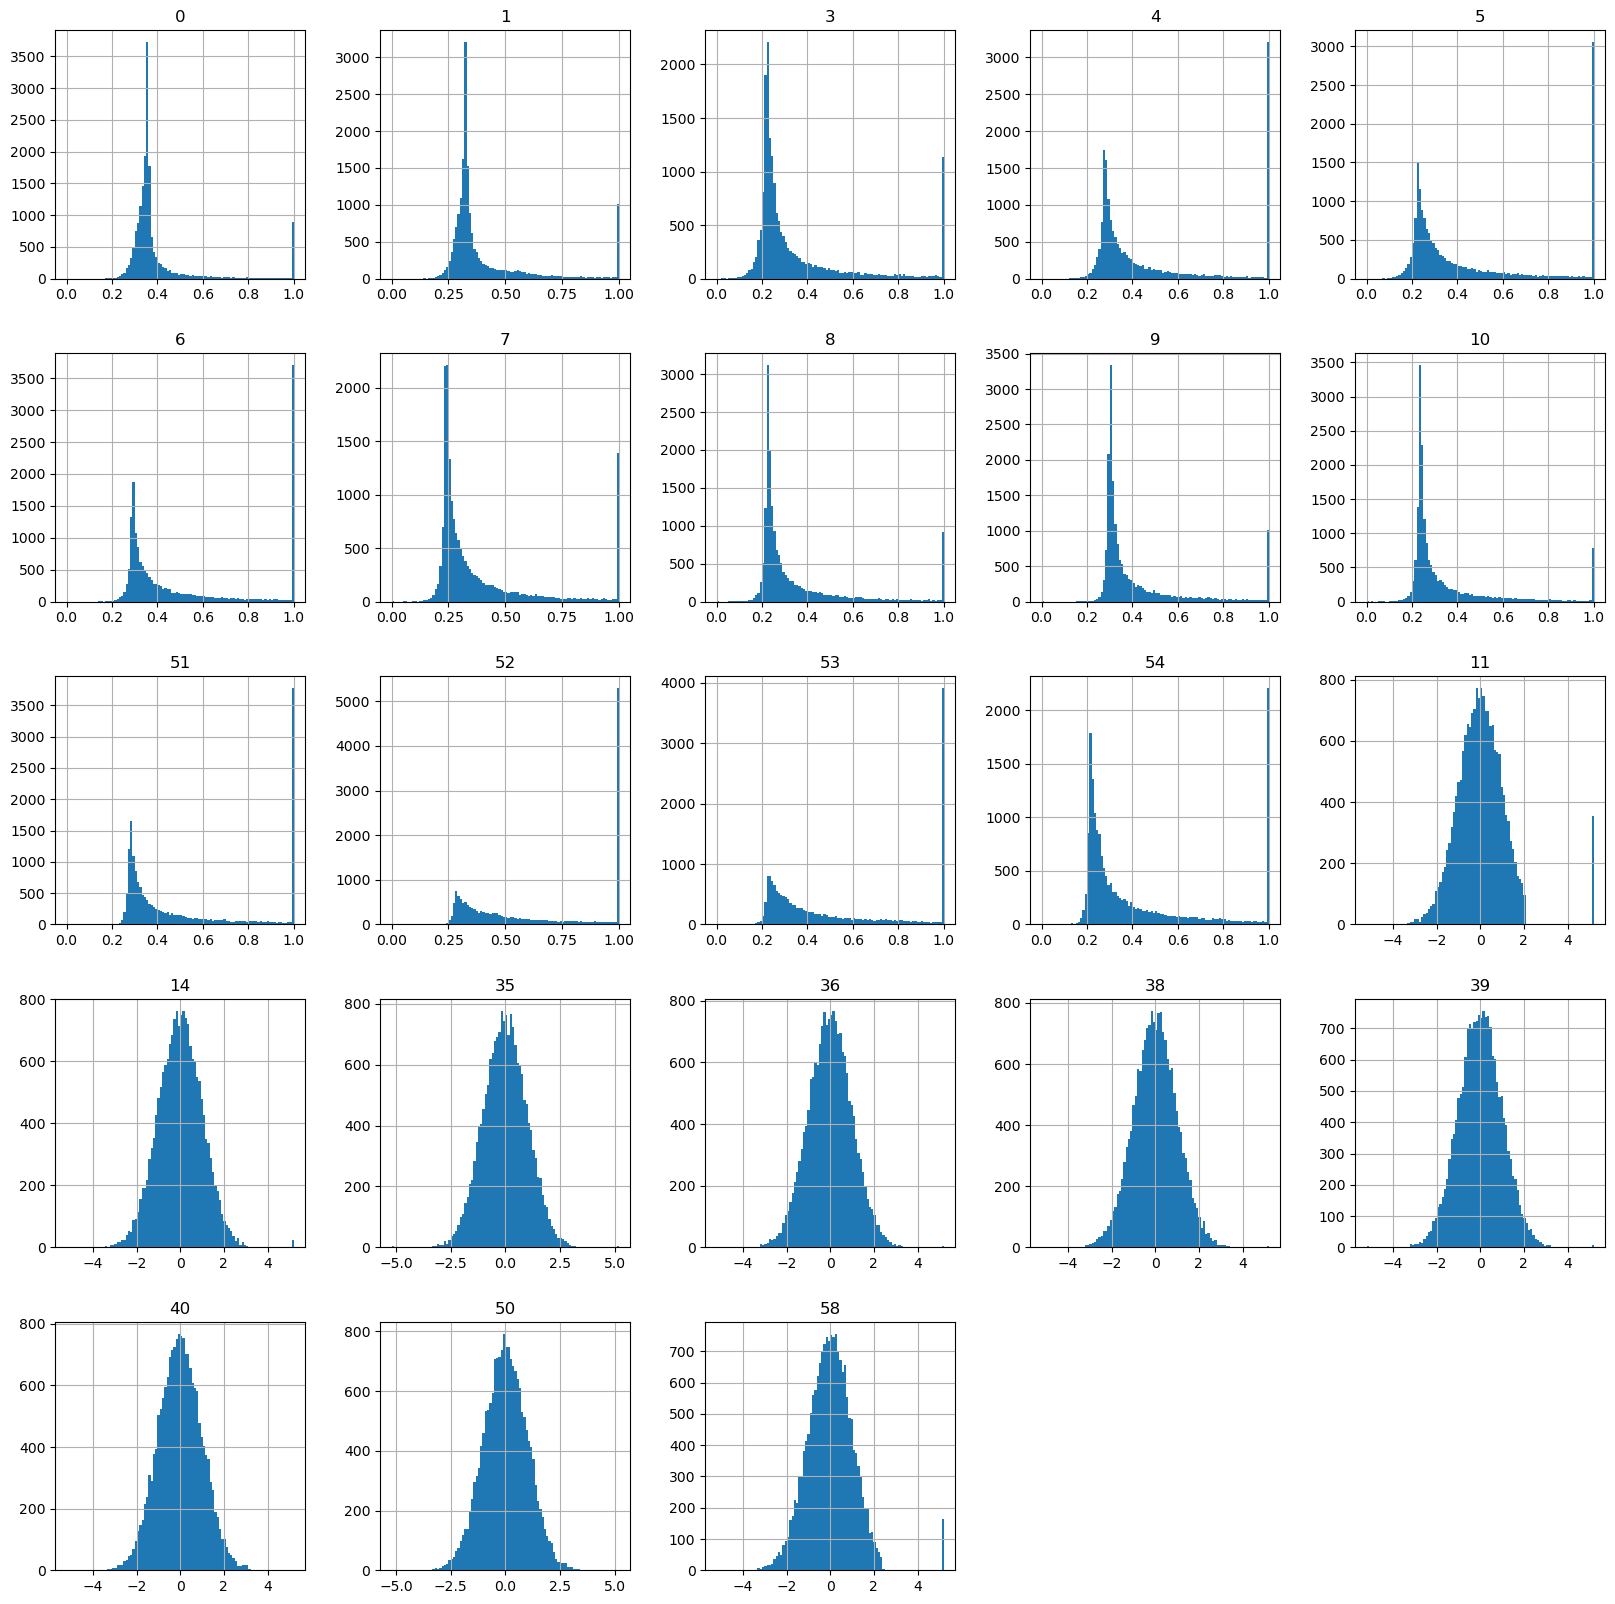

In [88]:
data.hist(figsize=(20, 20), bins = 100)
plt.show()

In [91]:
data = selected_df[final_cols]
data = data.drop(columns = [41, 42, 43, 37, 44, 47, 46, 49, 45, 48])
print(data.shape)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

# gaussian transform
from sklearn.preprocessing import QuantileTransformer

# Assuming 'df' is your DataFrame with binary features
gaussian_cols = [11, 14, 35, 36, 38, 39, 40, 50, 58]
transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_gaussianized = transformer.fit_transform(data[gaussian_cols])
df_gaussianized = pd.DataFrame(df_gaussianized, columns=gaussian_cols)
data = pd.concat([data.drop(columns = gaussian_cols), df_gaussianized], axis = 1)

data.columns = [idx for idx, col in enumerate(data.columns)]
data['label'] = selected_df['label'].values
client_split_indices = np.cumsum([df.shape[0] for df in selected_dfs[:-1]])
print(client_split_indices)
target_col = 'label'
data[target_col], codes = pd.factorize(data[target_col])
num_cols = data.columns.tolist()[:-1]
cat_cols = []

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [20, 19, 8, 3],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [0, 13, 15],
    'num_cols': len(num_cols),
    'task_type': 'classification',
    'clf_type': 'binary',
    'data_type': 'tabular',
    'client_split_indices': client_split_indices.tolist()
}


(18111, 23)
[ 1164  3164  5742  7545  9459 11413 13096 14899 16410]


In [93]:
print(data_config)

{'target': 'label', 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'split_col_idx': [20, 19, 8, 2], 'ms_col_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'obs_col_idx': [0, 13, 15], 'num_cols': 23, 'task_type': 'classification', 'clf_type': 'binary', 'data_type': 'tabular', 'client_split_indices': [1164, 3164, 5742, 7545, 9459, 11413, 13096, 14899, 16410]}


In [94]:
data.to_csv('./data/vehicle/data_cleaned.csv', index=False)
import json
with open('./data/vehicle/data_config.json', 'w') as f:
    json.dump(data_config, f)

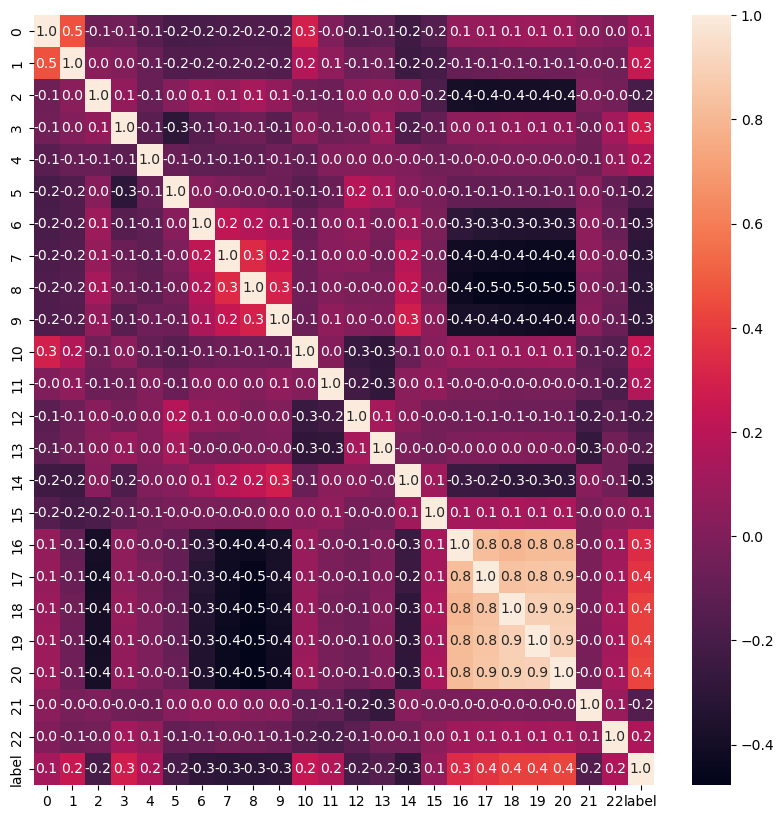

In [92]:
show_heatmap(data, figsize=(10, 10))

In [79]:
avg_correlation(data)

[(20, 0.3388140803160235),
 (19, 0.3362286272893472),
 (18, 0.3346896257345784),
 (17, 0.32272053455988603),
 (16, 0.31294554593014956),
 (23, 0.31114078803456857),
 (8, 0.23259038581648145),
 (7, 0.2252383332703754),
 (9, 0.22016677802514853),
 (6, 0.19868018803248297),
 (14, 0.19200785258763794),
 (2, 0.1783764567718933),
 (0, 0.1707068582815074),
 (1, 0.1654434250970536),
 (10, 0.15510742664966784),
 (3, 0.14081862370160503),
 (5, 0.13886916250994502),
 (12, 0.13138260633175008),
 (22, 0.13056192627882657),
 (13, 0.11678564016256238),
 (15, 0.11649104611776728),
 (11, 0.11071790111321464),
 (4, 0.10511667543512627),
 (21, 0.1035947126563339)]

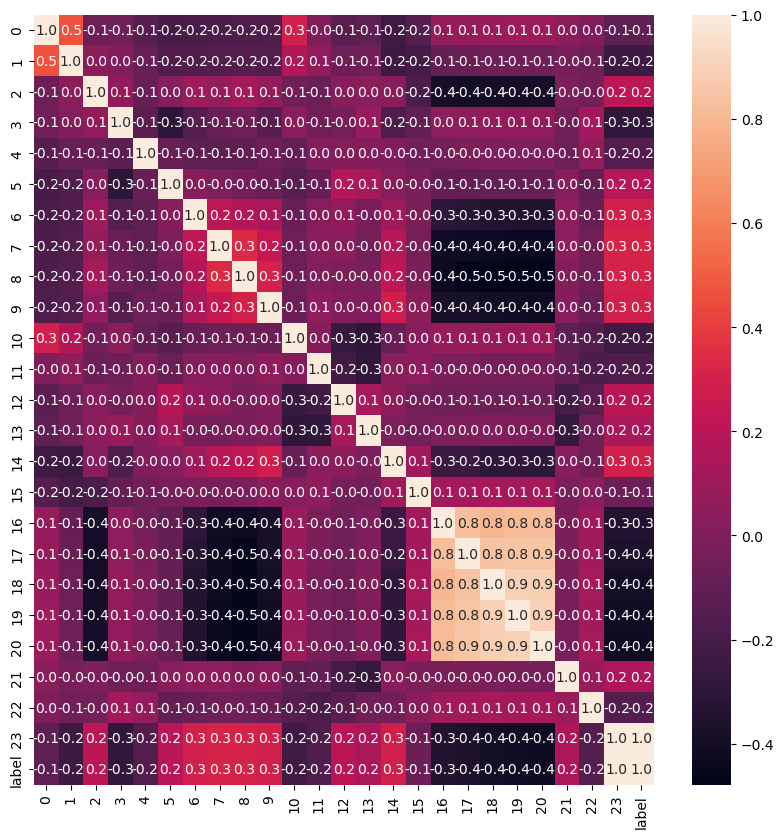

In [76]:
show_heatmap(data, figsize=(10, 10))

## Codon

In [4]:
data = pd.read_csv("./data/codon/codon_usage.csv", sep=',', low_memory=False)
data = data.dropna()
# data.columns = [str(i) for i in range(data.sh
data = data.drop(['SpeciesID', 'Ncodons', 'SpeciesName', 'DNAtype'], axis=1)
target_col = 'Kingdom'
data = data[data[target_col] != 'plm']
data[target_col], codes = pd.factorize(data[target_col])

num_cols = data.columns.tolist()[:-1]
cat_cols = []

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [0, 2, 1],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [0, 13, 15],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

print(data_config)

In [6]:
data.shape

(13008, 65)

In [19]:
cols = data.corrwith(data[target_col]).abs().sort_values(ascending = False)[0:30].index.tolist()

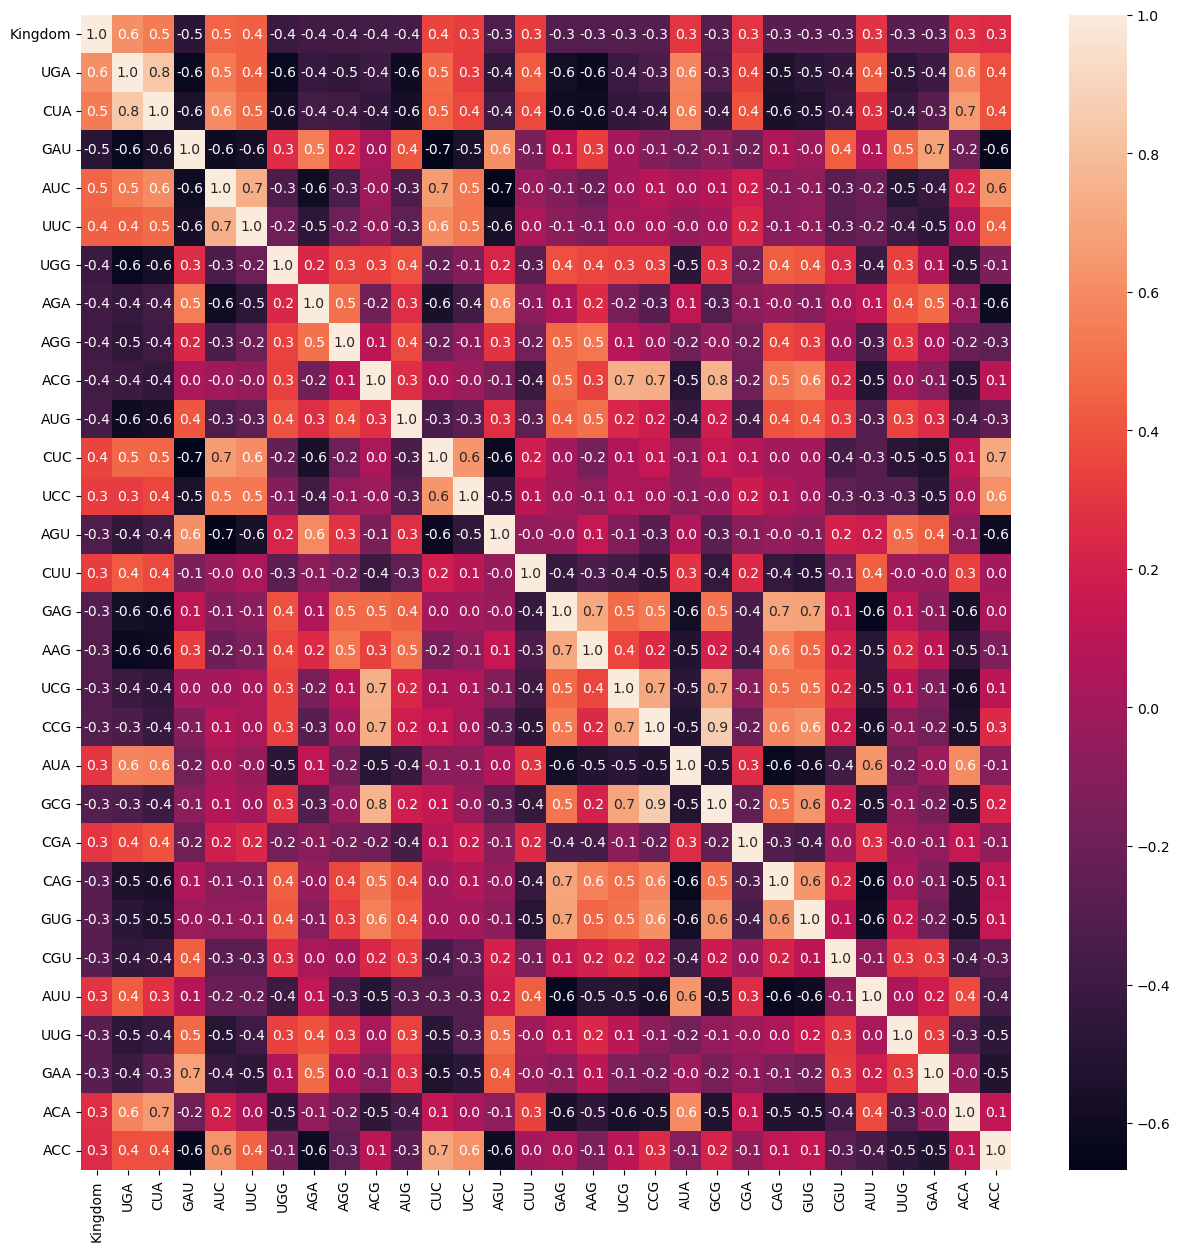

In [23]:
show_heatmap(data[cols], figsize=(15, 15))